# **1. IMPORT LIBRARIES AND FILES**

In [ ]:
# # Install geopandas and nltk library
# %pip install geopandas
# %pip install nltk

# Import other libraries
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn")

import nltk
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
# add regular stopwords
nltk.download("stopwords")
from nltk.corpus import stopwords
stops = stopwords.words("english")

import gzip
with gzip.open('listings.csv.gz') as f1:
  listings = pd.read_csv(f1)
with gzip.open('reviews.csv.gz') as f2:
  reviews = pd.read_csv(f2)

# **2. OBSERVE THE DATASET**

In [2]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6936 entries, 0 to 6935
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6936 non-null   int64  
 1   listing_url                                   6936 non-null   object 
 2   scrape_id                                     6936 non-null   int64  
 3   last_scraped                                  6936 non-null   object 
 4   source                                        6936 non-null   object 
 5   name                                          6936 non-null   object 
 6   description                                   6889 non-null   object 
 7   neighborhood_overview                         4850 non-null   object 
 8   picture_url                                   6936 non-null   object 
 9   host_id                                       6936 non-null   i

In [3]:
# Drop unused columns
df = listings[['id','host_id','host_response_time','host_response_rate','host_is_superhost','neighbourhood_cleansed','property_type','room_type',
               'amenities','price','availability_365','number_of_reviews','review_scores_rating','review_scores_accuracy',
               'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]
df.head(2)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6936 entries, 0 to 6935
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6936 non-null   int64  
 1   host_id                      6936 non-null   int64  
 2   host_response_time           5917 non-null   object 
 3   host_response_rate           5917 non-null   object 
 4   host_is_superhost            6927 non-null   object 
 5   neighbourhood_cleansed       6936 non-null   object 
 6   property_type                6936 non-null   object 
 7   room_type                    6936 non-null   object 
 8   amenities                    6936 non-null   object 
 9   price                        6936 non-null   object 
 10  availability_365             6936 non-null   int64  
 11  number_of_reviews            6936 non-null   int64  
 12  review_scores_rating         5611 non-null   float64
 13  review_scores_accu

In [4]:
# Drop the ones with no rating
df = df.dropna(subset='review_scores_rating') 

# Compute mean rating to use as "higher ratings"
df['review_scores_rating'].mean()

4.750308322937088

# **3. DIFFERENT NEIGHBOURHOODS IN SAN FRANCISCO**

In [5]:
# Create a dataframe containing information for different neighbourhoods in San Francisco
df_location = df[['id','property_type','price','neighbourhood_cleansed',
                  'review_scores_location','availability_365','number_of_reviews']]
# There are 22 Null rating elements so I decided to drop them
df_location.isna().sum()
df_location = df_location.dropna()
df_location.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5589 entries, 0 to 6932
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5589 non-null   int64  
 1   property_type           5589 non-null   object 
 2   price                   5589 non-null   object 
 3   neighbourhood_cleansed  5589 non-null   object 
 4   review_scores_location  5589 non-null   float64
 5   availability_365        5589 non-null   int64  
 6   number_of_reviews       5589 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 349.3+ KB


In [6]:
# We are now exploring the average rating by neighborhood
rating_map = df_location.groupby('neighbourhood_cleansed')['review_scores_location'].mean().sort_values(ascending=False).reset_index()
# Rename the columns for easy access
rating_map.columns = ['neighbourhood','average_rating']
rating_map.head()

,neighbourhood,average_rating
0,Presidio,4.961250
1,Castro/Upper Market,4.946420
2,Seacliff,4.941429
3,Pacific Heights,4.938168
4,Russian Hill,4.931406


In [7]:
# Check the unique neighborhood names and use them to compare to the geojson's file later
rating_map['neighbourhood'].unique()

array(['Presidio', 'Castro/Upper Market', 'Seacliff', 'Pacific Heights',
       'Russian Hill', 'Marina', 'Haight Ashbury', 'Chinatown',
       'Noe Valley', 'Financial District', 'North Beach',
       'Presidio Heights', 'Inner Richmond', 'Inner Sunset',
       'Western Addition', 'Diamond Heights', 'Outer Richmond',
       'West of Twin Peaks', 'Lakeshore', 'Glen Park', 'Parkside',
       'Potrero Hill', 'Bernal Heights', 'Nob Hill', 'Outer Sunset',
       'Ocean View', 'Mission', 'Twin Peaks', 'Excelsior',
       'Outer Mission', 'Crocker Amazon', 'Downtown/Civic Center',
       'Visitacion Valley', 'South of Market', 'Bayview'], dtype=object)

In [8]:
# Import a geojson's file containing San Francisco map with all the neighbourhood and load it in 'sf_neighborhoods'
import json

with open('sf_nhood.geojson', 'r') as f:
    sf_neighborhoods = json.load(f)

# Rename column as 'neighbourhood' to match with our table
for feature in sf_neighborhoods['features']:
    feature['properties']['neighbourhood'] = feature['properties'].pop('neighborho')

# Print the updated attribute keys for the first feature
print(sf_neighborhoods['features'][0]['properties'].keys())  

# Print out all of neighborhood names from geojson's file to double check with rating_map's 'neighbourhood'
nhood = []
for feature in sf_neighborhoods['features']:
    nhood.append(feature['properties']['neighbourhood'])
print(nhood)

dict_keys(['neighbourhood'])
['Seacliff', 'Haight Ashbury', 'Outer Mission', 'Inner Sunset', 'Downtown/Civic Center', 'Diamond Heights', 'Lakeshore', 'Russian Hill', 'Noe Valley', 'Treasure Island/YBI', 'Outer Richmond', 'Crocker Amazon', 'Excelsior', 'Parkside', 'Financial District', 'Ocean View', 'Mission', 'West of Twin Peaks', 'Inner Richmond', 'Marina', 'Bayview', 'Visitacion Valley', 'Pacific Heights', 'Presidio Heights', 'South of Market', 'Glen Park', 'Potrero Hill', 'Castro/Upper Market', 'Twin Peaks', 'Bernal Heights', 'Presidio', 'Nob Hill', 'Chinatown', 'North Beach', 'Outer Sunset', 'Western Addition', 'Golden Gate Park']


- It looks like the names are in the same formats and all of neighbourhood names from our dataset are present in the geojson's file. We can later use the geojson's file to plot.

- We now create 3 more dataframes for price, availability and demand by neighbourhood to plot.

In [9]:
# Add a clean 'price' column in float type to df_location
df_location.loc[:, 'new_price'] = df_location['price'].str.strip('$').str.replace(',', '').astype(float)

# Explore the average price by location
price_map = df_location.groupby('neighbourhood_cleansed')['new_price'].mean().sort_values(ascending=False).reset_index()
price_map.columns = ['neighbourhood','average_price']

# Explore the average availability in a year by location
availability_map = df_location.groupby('neighbourhood_cleansed')['availability_365'].mean().sort_values(ascending=False).reset_index()
availability_map.columns = ['neighbourhood','average_availability']

# Explore the average demand by location (using number_of_reviews since we don't have actual demand information)
demand_map = df_location.groupby('neighbourhood_cleansed')['number_of_reviews'].mean().sort_values(ascending=False).reset_index()
demand_map.columns = ['neighbourhood','average_demand']

# price_map.head()
# availability_map.head()
demand_map.head()

,neighbourhood,average_demand
0,Diamond Heights,138.416667
1,Seacliff,127.000000
2,West of Twin Peaks,106.966292
3,Presidio,105.875000
4,Outer Sunset,99.387097


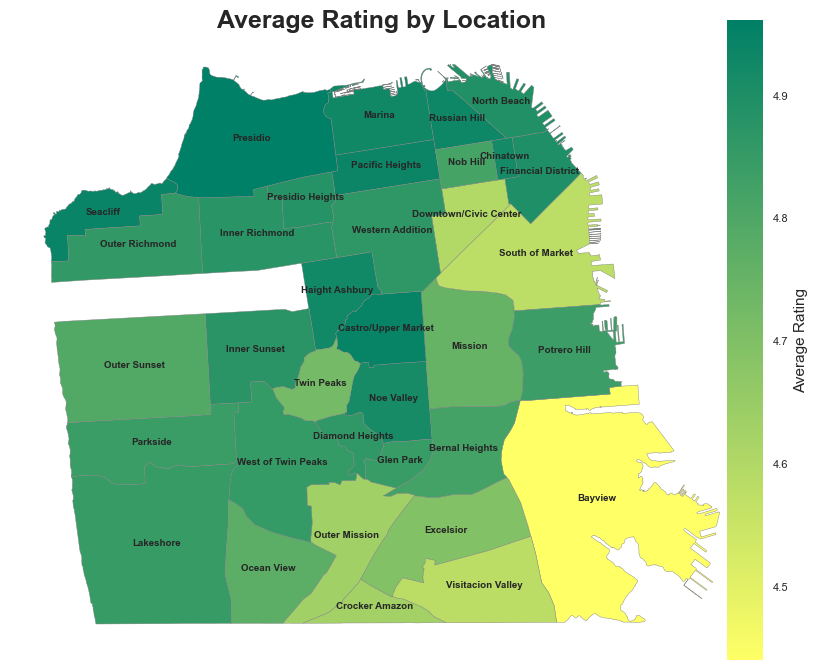

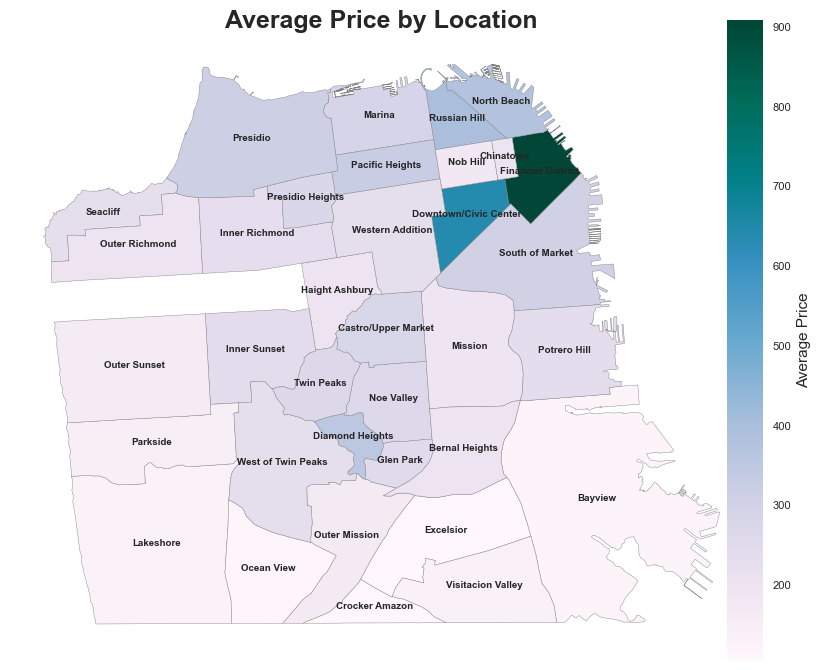

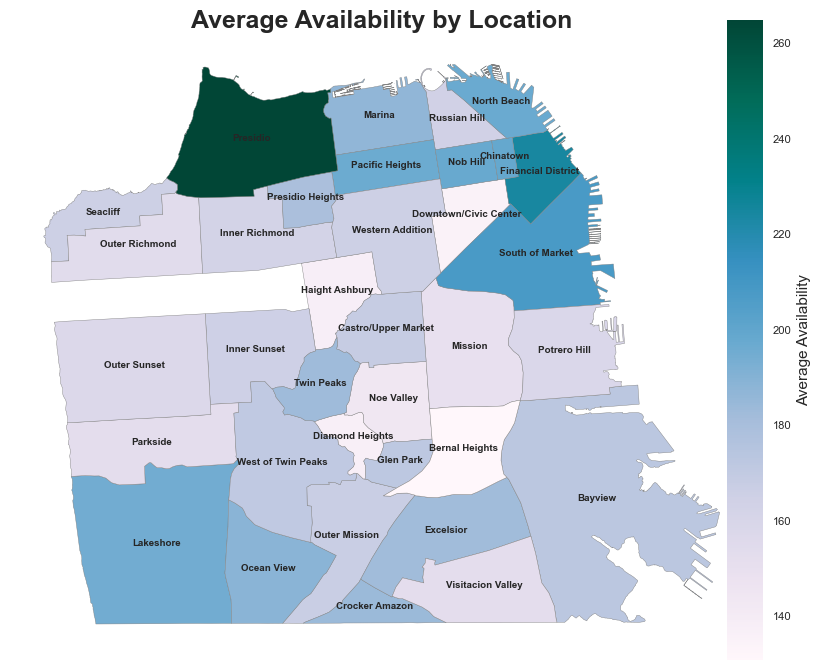

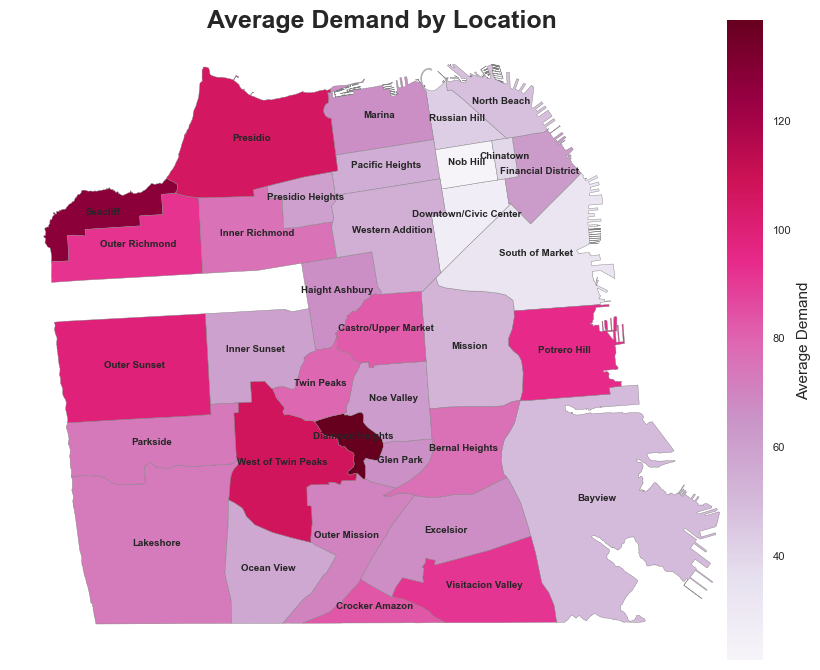

In [10]:
# Load the GeoJSON file containing SF neighborhood boundaries
sf_neighborhoods = gpd.read_file('sf_nhood.geojson')

# Rename the neighborhood column to match your availability data
sf_neighborhoods = sf_neighborhoods.rename(columns={'neighborho': 'neighbourhood'})

# Merge the 4 dataframes with the neighborhood boundaries based on the neighborhood name (all have 34 neighbourhood names, 34 rows)
sf_neighborhoods = sf_neighborhoods.merge(rating_map, on='neighbourhood')
sf_neighborhoods = sf_neighborhoods.merge(price_map, on='neighbourhood')
sf_neighborhoods = sf_neighborhoods.merge(availability_map, on='neighbourhood')
sf_neighborhoods = sf_neighborhoods.merge(demand_map, on='neighbourhood')

# Set up a list of color maps for each variable
cmaps = ['summer_r','PuBuGn','PuBuGn','PuRd']

# Loop through each variable and create a choropleth map
for i, col in enumerate(['average_rating','average_price','average_availability','average_demand']): # creates a loop that iterates over the list of variable names
    fig, ax = plt.subplots(figsize=(12,8))
    sf_neighborhoods.plot(column=col, cmap=cmaps[i], edgecolor='gray', ax=ax, facecolor='white')
    ax.set_axis_off()   # removes the x and y axis ticks and labels from the plot
    ax.set_title(col.replace('_', ' ').title()  + ' by Location', fontsize=18, fontweight='bold')
    colorbar_location = fig.add_axes([0.8, 0.1, 0.03, 0.8])
    sm = plt.cm.ScalarMappable(cmap=cmaps[i], norm=plt.Normalize(vmin=sf_neighborhoods[col].min(), 
                                                                 vmax=sf_neighborhoods[col].max()))  # creates a ScalarMappable object, which maps a range of data values to a range of colors using vmin and vmax
    sm._A = []          # '_A' attribute is set to an empty list to avoid a warning message about the color map being underspecified
    cbar = plt.colorbar(sm, cax=colorbar_location)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label(col.replace('_', ' ').title(), fontsize=11)
    sf_neighborhoods.apply(lambda x: ax.annotate(text=x.neighbourhood, 
                                             xy=x.geometry.centroid.coords[0], 
                                             ha='center',
                                             fontsize=7, 
                                             fontweight='bold'), axis=1)   #  adds texts using function to create an annotation with the neighborhood name at the centroid of the neighborhood's geometry
    plt.savefig(col + '_map.png')


# **4. AMENITY ACROSS DIFFERENT ROOM TYPES**

In [11]:
# Create df_am to explore amenities of rating >= 4.75
df_am = df[['id','room_type','amenities','review_scores_rating']]
df_am = df_am[df_am['review_scores_rating'] >= 4.75]
df_am.isna().sum() # there are no NaN values

id                      0
room_type               0
amenities               0
review_scores_rating    0
dtype: int64

In [12]:
# Define a function to convert the string to a list
def string_to_list(s):
    return s.strip('[]').replace("'", '').split(',')

# Apply the function to the amenities column
df_am['amenities'] = df_am['amenities'].apply(string_to_list)

# Create dataframes for each room types
df_entire = df_am[df_am['room_type']=='Entire home/apt']
df_private = df_am[df_am['room_type']=='Private room']
df_shared = df_am[df_am['room_type']=='Shared room']
df_hotel = df_am[df_am['room_type']=='Hotel room']

# Convert strings of amenity to lists
entire_list = df_entire['amenities'].to_list()
private_list = df_private['amenities'].to_list()
shared_list = df_shared['amenities'].to_list()
hotel_list = df_hotel['amenities'].to_list()

- I now create separate dataframes for each room type that count the number of times each amenity appears in the listings:

In [13]:
# Entire home
count_dict = {}
for list in entire_list:
    for item in list:
        if item in count_dict:
            count_dict[item] += 1
        else:
            count_dict[item] = 1

df_count_entire = pd.DataFrame(count_dict.items(), 
                               columns=['amenities', 'count']).sort_values(by='count', ascending=False).reset_index().drop(columns='index')

# Private room
count_dict = {}
for list in private_list:
    for item in list:
        if item in count_dict:
            count_dict[item] += 1
        else:
            count_dict[item] = 1

df_count_private = pd.DataFrame(count_dict.items(), 
                                columns=['amenities', 'count']).sort_values(by='count', ascending=False).reset_index().drop(columns='index')

# Shared room
count_dict = {}
for list in shared_list:
    for item in list:
        if item in count_dict:
            count_dict[item] += 1
        else:
            count_dict[item] = 1

df_count_shared = pd.DataFrame(count_dict.items(), 
                               columns=['amenities', 'count']).sort_values(by='count', ascending=False).reset_index().drop(columns='index')

# Hotel room
count_dict = {}
for list in hotel_list:
    for item in list:
        if item in count_dict:
            count_dict[item] += 1
        else:
            count_dict[item] = 1

df_count_hotel = pd.DataFrame(count_dict.items(), 
                              columns=['amenities', 'count']).sort_values(by='count', ascending=False).reset_index().drop(columns='index')
                       

- After looking at the top 20 of each room type, I found that safety features (Alarm|Fire extinguisher|First aid kit) are always on top,
and SF regulations require these features in all short-term rentals. Therefore, I will group them into safety feature category.
- Moreover, TV and Wifi are 2 features that appear a lot but they have different entry types. For example, TV can be under "55\" HDTV with Amazon Prime Video",
or "TV with standard cable". So I will group these two into 2 big groups of TV and Wifi as well to make sure I got all the data.
- And the rest can be by themselves since they are very specific.

In [14]:
# Define groups of feature
wifi_features = 'WIFI|wifi|Wifi|WiFi|Internet|internet|highspeed|Highspeed|Mbps|mbps'
tv_features = 'TV|tv|Tv|tivi|Tivi|Television|television'
safety_features = 'alarm|Alarm|Fire extinguisher'
add_all_3 = 'WIFI|wifi|Wifi|WiFi|Internet|internet|highspeed|Highspeed|Mbps|mbps|TV|tv|Tv|tivi|Tivi|Television|television|alarm|Alarm|Fire extinguisher'

# Check for different types of 'TV'
df_count_entire[df_count_entire['amenities'].str.contains(tv_features)].head(5)

,amenities,count
35,"""TV""",1073
58,"""TV with standard cable""",489
110,Apple TV,144
156,Fire TV,57
167,"""55\"" HDTV with Amazon Prime Video",45


- Create a function to plot amenities by different room types:

In [15]:
def plot_amenities_by_room_type(df, room_type, save_file_name):
    # Create separate dataframes for each amenity
    safety = df[df['amenities'].str.contains(safety_features)]
    wifi = df[df['amenities'].str.contains(wifi_features)]
    tv = df[df['amenities'].str.contains(tv_features)]
    others = df[~df['amenities'].str.contains(add_all_3)].reset_index().drop(columns='index')
    
    # Create dictionary to add onto the 'others' list
    dict_ = {'amenities': ['Safety features','Wifi','TV'],
             'count' : [safety['count'].sum(),wifi['count'].sum(),tv['count'].sum()]}
    df_ = pd.DataFrame(dict_)
    df_ = pd.concat([df_,others]).reset_index().drop(columns='index')
    
    # Extract top 5 categories and add 1 other categories to a final dataframe
    dict_other = {'amenities': 'Others',
                  'count': df_.iloc[6:]['count'].sum()}
    df_other = pd.DataFrame([dict_other])
    df_final = pd.concat([df_.iloc[:6],df_other]).reset_index().drop(columns='index')
    df_final['percentage'] = df_final['count']*100/df_final['count'].sum()
    df_final['amenities'] = df_final['amenities'].str.replace('"', '') # to clean up, get rid of ""
    
    # Create pie plots, set color palette and explode values
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    colors = sns.color_palette('Set3')
    explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

    # Subplot 1
    subplot1 = axs[0].pie(df_final['count'], labels=df_final['amenities'], colors=colors, 
                          explode=explode, textprops={'fontsize': 12})
    axs[0].set_title(room_type + ' Amenities', fontdict={"fontsize": 16,'fontweight': 'bold'})

    # Subplot 2
    wedges, texts, perc = axs[1].pie(df_final['count'], labels=df_final['amenities'], autopct='%1.2f%%', 
                                     pctdistance=0.85, colors=colors, explode=explode, textprops={'fontsize': 12})
    # Make the info of 'Others' slice invisible
    wedges[6].set_visible(False)
    texts[6].set_visible(False)
    perc[6].set_visible(False)
    # Adjust spacing btw subplot 1 and 2 to be 0.002 inches
    plt.subplots_adjust(wspace=0.002)
    axs[1].set_aspect('equal')
    axs[1].set_ylim([-0.98, 1.1])
    axs[1].set_xlim([-0.98, 1.1])
    
    plt.savefig(save_file_name)
    plt.show()


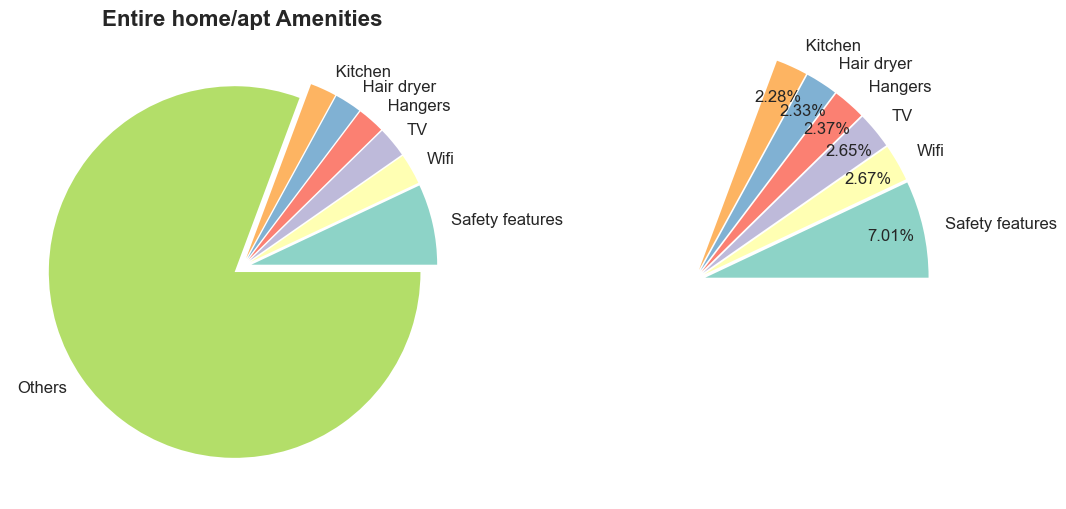

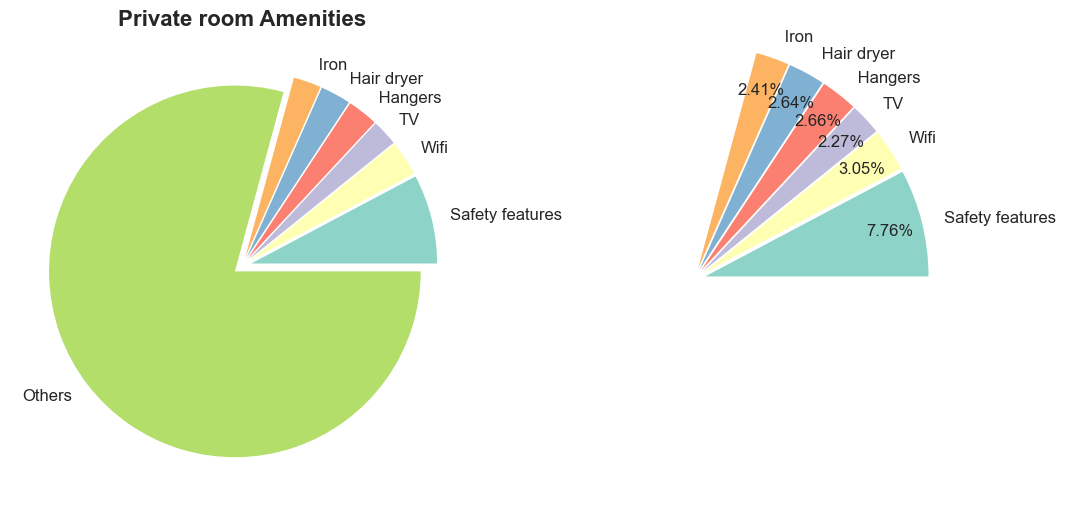

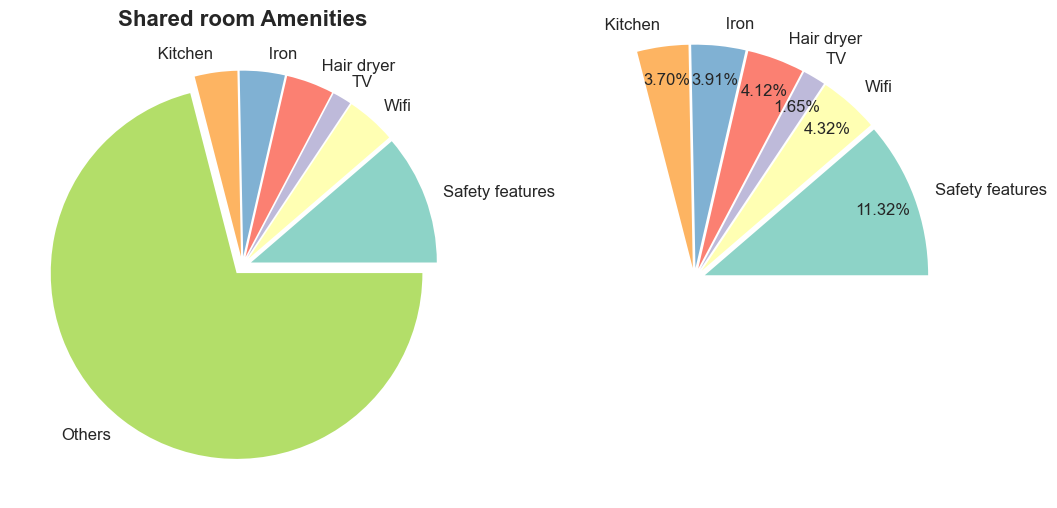

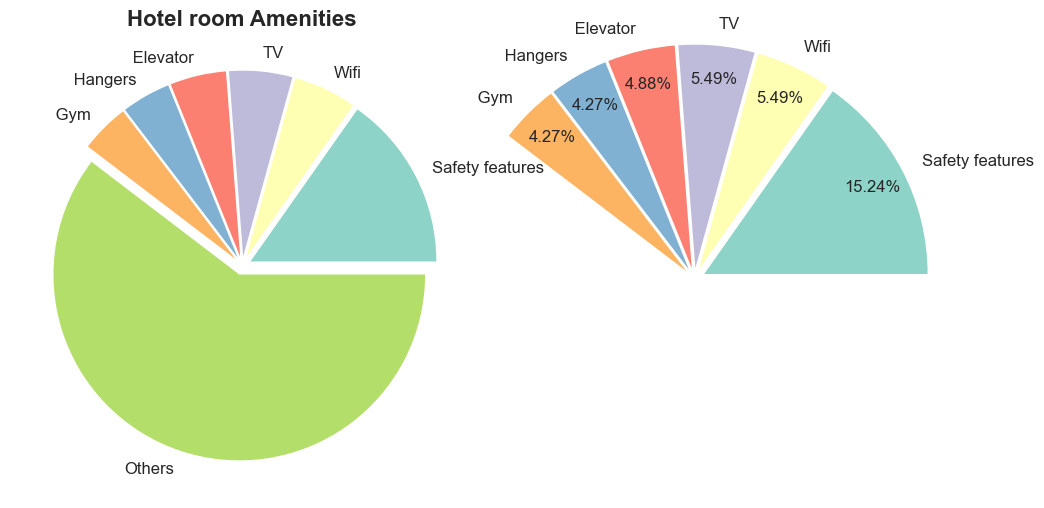

In [16]:
# Plots for different room types
plot_amenities_by_room_type(df_count_entire, 'Entire home/apt', 'EntireHomeApt.png')
plot_amenities_by_room_type(df_count_private, 'Private room', 'PrivateRoom.png')
plot_amenities_by_room_type(df_count_shared, 'Shared room', 'SharedRoom.png')
plot_amenities_by_room_type(df_count_hotel, 'Hotel room', 'HotelRoom.png')

# **5. SUPERHOST ANALYSIS**

In [ ]:
#  From AirBnB website: Maintaining a 4.8 overall rating, a response rate above 90%
df_superhost = df[['host_id','host_response_rate','host_is_superhost','review_scores_rating','review_scores_accuracy',
                   'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]
df_superhost = df_superhost.dropna()
# Clean up 'host_response_rate' and change type to int
df_superhost['host_response_rate'] = df_superhost['host_response_rate'].str.strip('%').astype(int)
# Group by 'host_id'
df_superhost = df_superhost.groupby('host_id')[['host_response_rate','review_scores_rating','host_is_superhost','review_scores_accuracy',
                                    'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',
                                    'review_scores_value']].mean().reset_index()
# Merge df_superhost and 2 columns from df, but we have too many duplicates
s_data = df_superhost.merge(df[['host_id','host_is_superhost']], on='host_id', how='left')
s_data.duplicated().sum()

In [18]:
# The duplicates can be dropped based on the folowing table
s_data.head(10)

,host_id,host_response_rate,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_is_superhost
0,1169,100.0,4.8700,4.93,4.920,4.9500,4.8800,4.980,4.760,t
1,7149,100.0,4.8400,4.97,4.910,4.8800,4.9400,4.905,4.660,t
2,7149,100.0,4.8400,4.97,4.910,4.8800,4.9400,4.905,4.660,t
3,8904,80.0,4.8800,4.85,4.870,4.8900,4.8500,4.770,4.680,f
4,10135,100.0,4.7225,4.84,4.825,4.8925,4.9225,4.360,4.620,t
5,10135,100.0,4.7225,4.84,4.825,4.8925,4.9225,4.360,4.620,t
6,10135,100.0,4.7225,4.84,4.825,4.8925,4.9225,4.360,4.620,t
7,10135,100.0,4.7225,4.84,4.825,4.8925,4.9225,4.360,4.620,t
8,16382,100.0,5.0000,4.99,4.995,4.9800,4.9950,4.890,4.905,t
9,16382,100.0,5.0000,4.99,4.995,4.9800,4.9950,4.890,4.905,t


In [19]:
# Drop duplicates
s_data = s_data.drop_duplicates()

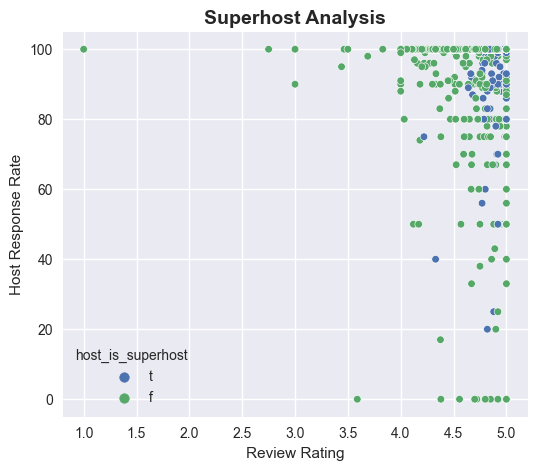

In [20]:
# Plot superhost data => 4.8 overall rating, a response rate above 90%
plt.figure(figsize=(6,5))
sns.scatterplot(data=s_data, x='review_scores_rating', y='host_response_rate', hue='host_is_superhost', s=30)
plt.xlabel('Review Rating')
plt.ylabel('Host Response Rate')
plt.title('Superhost Analysis', fontweight='bold', fontsize=14)
plt.show()

# **6. CREATE WORDCLOUD OF REVIEWS**

In [21]:
# Find the average rating to set for "high rating"
df['review_scores_rating'].mean()

4.750308322937088

In [22]:
# Drop 49 Null comments in review table
reviews.dropna(inplace=True)

# Create temp table and rename columns
temp = df[['id','review_scores_rating']]
temp.columns = ['listing_id','review_scores_rating']

# Merge reviews table and temp table into df_reviews for wordclouds
df_reviews = reviews.merge(temp, on='listing_id', how='left')

# Only choose very high and very low ratings
df_reviews = df_reviews[(df_reviews['review_scores_rating']>=4.75) | (df_reviews['review_scores_rating']<=2.5)][['listing_id','review_scores_rating','comments']]
df_reviews.head(2)

,listing_id,review_scores_rating,comments
0,958,4.87,"Our experience was, without a doubt, a five st..."
1,958,4.87,Returning to San Francisco is a rejuvenating t...


In [23]:
# Create function to get rid of symbols, \n and to lowercase words
general = ['wa','room','day','would','great','place','stay','one','san','francisco']

def clean_review(x):
  new_review = re.sub('\n', ' ', x)
  new_review = re.sub('[^a-zA-Z]',' ', new_review).lower()
  new_review = [lemmatizer.lemmatize(x) for x in new_review.split() 
                if (lemmatizer.lemmatize(x) not in stops and len(x) > 2 and lemmatizer.lemmatize(x) not in general)]
  return ' '.join(new_review)

# Clean up 'comments' column
df_reviews['clean_comments'] = df_reviews['comments'].apply(clean_review)
df_reviews.head(2)

,listing_id,review_scores_rating,comments,clean_comments
0,958,4.87,"Our experience was, without a doubt, a five st...",experience without doubt five star experience ...
1,958,4.87,Returning to San Francisco is a rejuvenating t...,returning rejuvenating thrill time enhanced ho...


In [24]:
# Create function to count important words ONLY (high rating version)
high_rating_dict = {}
def count_words(sentence):
    for word in sentence.split():
        if word not in high_rating_dict:
            high_rating_dict[word] = 1
        else:
            high_rating_dict[word] += 1
    return high_rating_dict

df_reviews[df_reviews['review_scores_rating']>=4.75]['clean_comments'].apply(count_words)
pd.Series(high_rating_dict).sort_values(ascending=False)[:10]

location       84453
host           78812
clean          77084
comfortable    52735
nice           51779
recommend      46155
home           45545
everything     43535
apartment      42999
easy           41457
dtype: int64

In [25]:
#Create function to count important words ONLY (low rating version)
low_rating_dict = {}
def count_words(sentence):
    for word in sentence.split():
        if word not in low_rating_dict:
            low_rating_dict[word] = 1
        else:
            low_rating_dict[word] += 1
    return low_rating_dict

df_reviews[df_reviews['review_scores_rating']<=2.5]['clean_comments'].apply(count_words)
pd.Series(low_rating_dict).sort_values(ascending=False)[:10]

host           39
reservation    28
arrival        26
canceled       25
posting        22
automated      22
apt            17
time           15
issue          15
get            14
dtype: int64

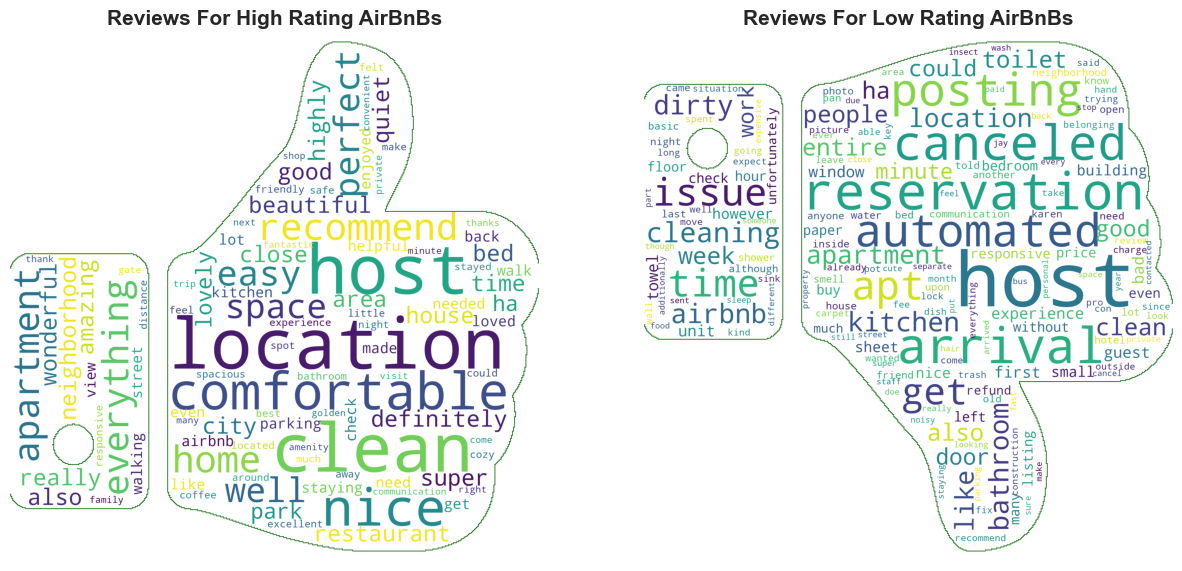

In [26]:
# Create wordcloud
# %pip install wordcloud
# %pip install PIL

from wordcloud import WordCloud
from PIL import Image

# Define two count_words lists here
count_words_1 = high_rating_dict
count_words_2 = low_rating_dict

# Create thumbs up and thumbs down masks for our wordclouds
mask_1 = Image.open("thumbsup.png")
mask_2 = Image.open("thumbsdown.png")

# Turn the masks transparent by convert them to RGBA first, set alpha channel of white pixels to 0
mask_1 = mask_1.convert('RGBA')
mask_2 = mask_2.convert('RGBA')
mask_1 = np.array(mask_1)
mask_2 = np.array(mask_2)
mask_1[mask_1[:,:,0] == 255, :] = [255, 255, 255, 0]
mask_2[mask_2[:,:,0] == 255, :] = [255, 255, 255, 0]


# Define two WordCloud objects
wordcloud_1 = WordCloud(background_color = 'white', mask = mask_1, scale=4,
                        contour_color='darkgreen', contour_width=0.5, min_font_size=6.5).generate_from_frequencies(count_words_1)
wordcloud_2 = WordCloud(background_color = 'white', mask = mask_2, scale=4,
                        contour_color='darkgreen', contour_width=0.5, min_font_size=6.5).generate_from_frequencies(count_words_2)

# Define two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Plot the first wordcloud on the first subplot
axs[0].imshow(wordcloud_1)
axs[0].set_title('Reviews For High Rating AirBnBs', size=15, weight='bold')

# Plot the second wordcloud on the second subplot
axs[1].imshow(wordcloud_2)
axs[1].set_title('Reviews For Low Rating AirBnBs', size=15, weight='bold')

# Remove the axis ticks and labels from both subplots
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

# Show the plot
plt.savefig("wordclouds.png")
plt.show()

# **EXTRA: INTERACTIVE MAPS OF SAN FRANCISCO**

- Using ***Folium*** to map interactive maps of San Francisco showing how rating, price, availability and demand vary across different areas.

In [27]:
# %pip install folium
import folium

# Create a map centered on San Francisco
rating_map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Create a choropleth layer using the 'neighbourhood'' and 'average_rating' columns from rating_map
choropleth = folium.Choropleth(
    geo_data=sf_neighborhoods,
    data=rating_map,
    columns=['neighbourhood','average_rating'],
    key_on='feature.properties.neighbourhood',
    fill_color='Blues',
    fill_opacity=1.0,
    line_opacity=0.3,
    legend_name='Review Scores by Location').add_to(rating_map_sf)

# Add neighborhood names to the map using GeoJsonTooltip
tooltip = folium.GeoJsonTooltip(
    fields=['neighbourhood'],
    aliases=['Neighborhood:'],
    localize=True)
choropleth.geojson.add_child(tooltip)
folium.LayerControl().add_to(rating_map_sf)
rating_map_sf.save('rating_map_sf.html')
rating_map_sf


In [28]:
# Create a map centered on San Francisco
price_map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Create a choropleth layer using the 'neighbourhood'' and 'average_price' columns from price_map
choropleth = folium.Choropleth(
    geo_data=sf_neighborhoods,
    data=price_map,
    columns=['neighbourhood','average_price'],
    key_on='feature.properties.neighbourhood',
    fill_color='PuBuGn',
    fill_opacity=1.0,
    line_opacity=0.3,
    legend_name='Average Price by Location [$ US Dollars]').add_to(price_map_sf)

# Add neighborhood names to the map using GeoJsonTooltip
tooltip = folium.GeoJsonTooltip(
    fields=['neighbourhood'],
    aliases=['Neighborhood:'],
    localize=True)
choropleth.geojson.add_child(tooltip)
folium.LayerControl().add_to(price_map_sf)
price_map_sf.save('price_map_sf.html')
price_map_sf

In [29]:
# Create a map centered on San Francisco
availability_map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Create a choropleth layer using the 'neighbourhood'' and 'average_availability' columns from availability_map
choropleth = folium.Choropleth(
    geo_data=sf_neighborhoods,
    data=availability_map,
    columns=['neighbourhood','average_availability'],
    key_on='feature.properties.neighbourhood',
    fill_color='Reds',
    fill_opacity=1.0,
    line_opacity=0.3,
    legend_name='Availability in A Year by Location [Days]').add_to(availability_map_sf)
# Add neighborhood names to the map using GeoJsonTooltip
tooltip = folium.GeoJsonTooltip(
    fields=['neighbourhood'],
    aliases=['Neighborhood:'],
    localize=True)
choropleth.geojson.add_child(tooltip)
folium.LayerControl().add_to(availability_map_sf)
availability_map_sf.save('availability_map_sf.html')
availability_map_sf

In [30]:
# Create a map centered on San Francisco
demand_map_sf = folium.Map(location=[37.7749, -122.4194], zoom_start=12)

# Create a choropleth layer using the 'neighbourhood'' and 'average_demand' columns from demand_map
choropleth = folium.Choropleth(
    geo_data=sf_neighborhoods,
    data=demand_map,
    columns=['neighbourhood','average_demand'],
    key_on='feature.properties.neighbourhood',
    fill_color='Purples',
    fill_opacity=1.0,
    line_opacity=0.3,
    legend_name='Demand by Location').add_to(demand_map_sf)

# Add neighborhood names to the map using GeoJsonTooltip
tooltip = folium.GeoJsonTooltip(
    fields=['neighbourhood'],
    aliases=['Neighborhood:'],
    localize=True)
choropleth.geojson.add_child(tooltip)
folium.LayerControl().add_to(demand_map_sf)
demand_map_sf.save('demand_map_sf.html')
demand_map_sf